## Построение модели предсказания проката велосипедов
На основе проведенного EDA построим пайплайн обработки данных и обучим несколько моделей

In [204]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [408]:
def rmsle(y, y_pred):
    return np.mean((np.log1p(y) - np.log1p(y_pred))**2)**0.5

### Baseline
Простая модель (линейная регрессия с L1 регуляризацией) с простым трансформером: только с исходыми признакаками без парсинга даты.

In [149]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

# baseline: трансформер с минимальной обработкой фичей (без разбиения даты и выделения новых признаков)

class TransformerBaseline(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_columns = ['season', 'holiday', 'workingday', 'weather']
        self.num_columns =  ['temp', 'atemp', 'windspeed', 'humidity']
        self.onehots = {col: OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore') for col in self.cat_columns}
        self.fillnans = {}
        
    def fit(self, X, y):
        X_fit = X[self.cat_columns + self.num_columns]
        
        # закдируем категориальные колонки через OneHotEncoding:
        for col in self.cat_columns:
            transformed = self.onehots[col].fit_transform(X_fit[[col]].fillna(X_fit[col].mode()[0]))
            X_fit = pd.concat([X_fit, pd.DataFrame(transformed, columns=self.onehots[col].get_feature_names_out([col]))], axis=1)
        
        X_fit = X_fit.drop(self.cat_columns, axis = 1)
        
        # будем заполнять NaN самым популярным. Сформируем набор значений
        for col in X_fit.columns:
            self.fillnans[col] = X_fit[col].mode()[0]
            X_fit[col] = X_fit[col].fillna(self.fillnans[col])
        
        return self
    
    def transform(self, X):
        temp = X[self.cat_columns + self.num_columns]
        
        onehot_df = pd.DataFrame()
        #temp.replace({'weather': {4: 3}}, inplace=True)
        
        #onehot encoding:
        for col in self.cat_columns:
            transformed = self.onehots[col].transform(temp[[col]].fillna(temp[col].mode()[0]))
            onehot_df = pd.concat([onehot_df, pd.DataFrame(transformed, columns=self.onehots[col].get_feature_names_out([col]))], axis=1)
        
        if not onehot_df.empty:
            onehot_df = onehot_df.set_index(temp.index)
            temp = pd.concat([temp, onehot_df], axis=1)
        
        temp = temp.drop(self.cat_columns, axis=1)
        
        # будем заполнять NaN самым популярным. Сформируем набор значений
        for col in temp.columns:
            temp[col] = temp[col].fillna(self.fillnans[col])
        #
        return temp

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [17]:
## Загрузка данных для обучения
data = pd.read_csv('data/train.csv', sep=',')
X = data.drop('count', axis=1)
y = data['count']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

MSE on train: 23511.164048334416
MAE on test: 25869.24633182564


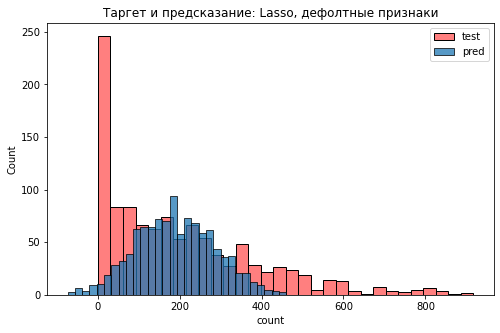

In [391]:
baseline_pipe = Pipeline([('transformer', TransformerBaseline()),
                          ('scaler', MinMaxScaler()),
                          ('model', Lasso(alpha=0.002))])
baseline_pipe.fit(X_train, y_train)
y_pred = baseline_pipe.predict(X_test)

print(f'MSE on train: {np.mean((y_train - baseline_pipe.predict(X_train))**2)}')
print(f'MAE on test: {np.mean((y_test - y_pred)**2)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: Lasso, дефолтные признаки')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

MSE on train: 29194.177344235723
MSE on test: 32593.944775500073


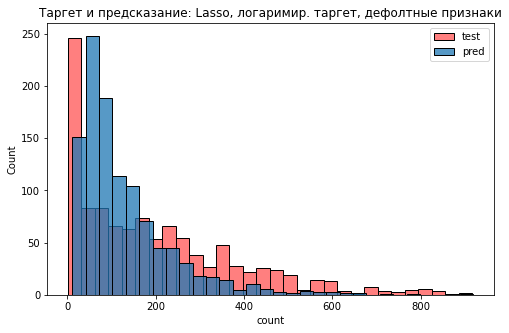

In [392]:
# Линейная регрессия с логарифмированием таргета
from sklearn.compose import TransformedTargetRegressor

baseline_pipe = Pipeline([('transformer', TransformerBaseline()),
                          ('scaler', MinMaxScaler()),
                          ('model', Lasso(alpha=0.0005))])

baseline_log = TransformedTargetRegressor(
    regressor=baseline_pipe, func=np.log1p, inverse_func=np.expm1)

baseline_log.fit(X_train, y_train)
y_pred = baseline_log.predict(X_test)

print(f'MSE on train: {np.mean((y_train - baseline_log.predict(X_train))**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: Lasso, логаримир. таргет, дефолтные признаки')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

Как видно, качество не очень хорошее. Сделаем продвинутый трансформер, с парсиногом даты и времени и выделением дополнительных признаков

In [191]:
# baseline: трансформер с минимальной обработкой фичей (без разбиения даты и выделения новых признаков)

class Transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_columns = ['season', 'holiday', 'workingday', 'weather']
        self.num_columns =  ['temp', 'windspeed', 'humidity']
        self.n_ohe = 4
        
        self.onehots = {}
        self.meantargets = {}
        self.fillnans = {}
        self.datetime_start = None
        self.twilight_time = pd.read_csv('data/twilight_time.csv', sep=',')
        
    def fit(self, X, y):
        X_fit = X.copy()
        
        datetime_col = pd.to_datetime(X_fit['datetime'])
        self.datetime_start = datetime_col.iloc[0]
        
        X_fit['hour'] = datetime_col.dt.hour # часы для дневной сезонности
        X_fit['day'] = datetime_col.dt.day # часы для дневной сезонности
        X_fit['year'] = datetime_col.dt.year # парсинг тренда по годам 
        X_fit['month'] = datetime_col.dt.month # месяцы для годичной сезонности
        X_fit['total_hours'] = (datetime_col - self.datetime_start).dt.total_seconds() / (3600.0) # временной ряд
        
        # 
        X_fit = X_fit.merge(self.twilight_time, how='left', on=['month', 'day'])
        X_fit['is_daylight'] = ((X_fit['twilight_start_hour'] < X_fit['hour']) &
                            (X_fit['twilight_end_hour'] > X_fit['hour'])).replace({True: 1, False: 0})
        
        # разность температур
        X_fit['dtemp'] = X_fit['temp'] - X_fit['atemp']
        
        # обновляем списки какегориальных и числовых признаков
        self.cat_columns = self.cat_columns + ['hour', 'year', 'month', 'is_daylight']
        self.num_columns = self.num_columns + ['total_hours', 'dtemp']
        
        # оставляем только признаки из списков
        X_fit = X_fit[self.cat_columns + self.num_columns]
        X_fit['y'] = y
        
        # Заполняем словарь значениями для заполнения пропусков категорий. Вручную выберем значения, бзизкие к средним по таргету.
        self.fillnans = {'season': 2, 'holiday': 0, 'workingday': 0, 'weather': 1, 'hour': 12, 
                         'year': 2012, 'month': 5, 'is_daylight': 1}
        # Для числовых значкений берем среднее 
        for col in self.num_columns:
            self.fillnans[col] = X_fit[col].mean()
        
        # закдируем категориальные колонки через OneHotEncoding либо meantarget:
        for col in self.cat_columns:
            if X_fit[col].value_counts().shape[0] <= self.n_ohe:
                self.onehots[col] = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
                transformed = self.onehots[col].fit_transform(X_fit[[col]].fillna(self.fillnans[col]))
                X_fit = pd.concat([X_fit, pd.DataFrame(transformed, columns=self.onehots[col].get_feature_names_out([col]))], axis=1)
            else:
                self.meantargets[col] = X_fit.groupby(col, dropna=True)['y'].mean()
        
        X_fit = X_fit.drop(self.onehots.keys(), axis = 1)
        
        # будем заполнять NaN самым популярным. Сформируем набор значений
        for col in X_fit.columns:
            self.fillnans[col] = X_fit[col].mode()[0]
            X_fit[col] = X_fit[col].fillna(self.fillnans[col])
        
        return self
    
    def transform(self, X):
        temp = X.copy()
        datetime_col = pd.to_datetime(temp['datetime'])
        
        temp['hour'] = datetime_col.dt.hour # часы для дневной сезонности
        temp['year'] = datetime_col.dt.year # парсинг тренда по годам
        temp['day'] = datetime_col.dt.day # парсинг тренда по годам 
        temp['month'] = datetime_col.dt.month # месяцы для годичной сезонности
        temp['total_hours'] = (datetime_col - self.datetime_start).dt.total_seconds() / (3600.0) # временной ряд
        
        # разность температур
        temp['dtemp'] = temp['temp'] - temp['atemp']
        
        # признак светлого времени суток
        temp = temp.merge(self.twilight_time, how='left', on=['month', 'day'])
        temp['is_daylight'] = ((temp['twilight_start_hour'] < temp['hour']) &
                               (temp['twilight_end_hour'] > temp['hour'])).replace({True: 1, False: 0})
        
        temp = temp[self.cat_columns + self.num_columns]
        
        onehot_df = pd.DataFrame()
        #temp.replace({'weather': {4: 3}}, inplace=True)
        
        #onehot encoding:
        for col in self.cat_columns:
            if col in self.onehots:
                transformed = self.onehots[col].transform(temp[[col]].fillna(self.fillnans[col]))
                onehot_df = pd.concat([onehot_df, pd.DataFrame(transformed, columns=self.onehots[col].get_feature_names_out([col]))], axis=1)
            else:
                temp[col] = temp[col].map(self.meantargets[col])
            
        if not onehot_df.empty:
            onehot_df = onehot_df.set_index(temp.index)
            temp = pd.concat([temp, onehot_df], axis=1)
        
        temp = temp.drop(self.onehots.keys(), axis=1)
        
        # будем заполнять NaN самым популярным. Сформируем набор значений
        for col in temp.columns:
            temp[col] = temp[col].fillna(self.fillnans[col])
            
        #
        
        return temp

In [193]:
# пример работы трансформера
tr_base = Transformer()
tr_base.fit(X, y)
tr_base.transform(X).head(10)

,hour,month,temp,windspeed,humidity,total_hours,dtemp,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,year_2012,is_daylight_1
0,55.138462,90.366516,9.84,0.0000,81,0.0,-4.555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33.859031,90.366516,9.02,0.0000,80,1.0,-4.615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.899554,90.366516,9.02,0.0000,80,2.0,-4.615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.757506,90.366516,9.84,0.0000,75,3.0,-4.555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.407240,90.366516,9.84,0.0000,75,4.0,-4.555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,19.767699,90.366516,9.84,6.0032,75,5.0,-3.040,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,76.259341,90.366516,9.02,0.0000,80,6.0,-4.615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,213.116484,90.366516,8.20,0.0000,86,7.0,-4.680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,362.769231,90.366516,9.84,0.0000,75,8.0,-4.555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,221.780220,90.366516,13.12,0.0000,76,9.0,-4.305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


MSE on train: 15902.492595828116
MSE on test: 17074.023349315143


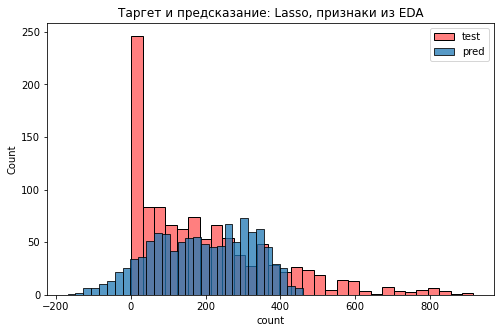

In [393]:
# Линейная регрессия с логарифмированием таргета
from sklearn.compose import TransformedTargetRegressor

linreg_pipe = Pipeline([('transformer', Transformer()),
                          ('scaler', MinMaxScaler()),
                          ('model', Lasso(alpha=0.001))])

linreg_pipe.fit(X_train, y_train)
y_pred = linreg_pipe.predict(X_test)

print(f'MSE on train: {np.mean((y_train - linreg_pipe.predict(X_train))**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: Lasso, признаки из EDA')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

MSE on train: 9199.547810852046
MSE on test: 10157.212528169717


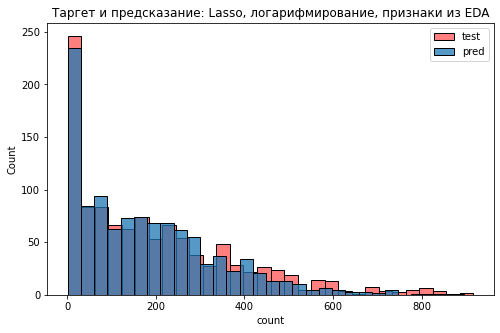

In [394]:
# Линейная регрессия с логарифмированием таргета
from sklearn.compose import TransformedTargetRegressor

linreg_pipe_log = Pipeline([('transformer', Transformer()),
                          ('scaler', MinMaxScaler()),
                          ('model', Lasso(alpha=0.0001))])

linreg_log = TransformedTargetRegressor(
    regressor=linreg_pipe_log, func=np.log1p, inverse_func=np.expm1)

linreg_log.fit(X_train, y_train)
y_pred = linreg_log.predict(X_test)
y_pred_train = linreg_log.predict(X_train)

print(f'MSE on train: {np.mean((y_train - y_pred_train)**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: Lasso, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

При сравнении распределений и по метрике MSE получился достаточно хороший прирост качества по сравнению с со старым вариантом трансформера.

Зафиксируем бейслайн: линейная регрессия с L1 регуляризацией на трансформере со всеми признаками.

In [343]:
print(f'Baseline MSE on train: {np.mean((y_train - y_pred_train)**2)}')
print(f'Baseline MSE on test: {np.mean((y_test - y_pred)**2)}')

Baseline MSE on train: 9199.547810852046
Baseline MSE on test: 10157.212528169717


### Обучение сложных моделей

#### Случайный лес

MSE on train: 342.17221730121594
MSE on test: 2546.9891484848476


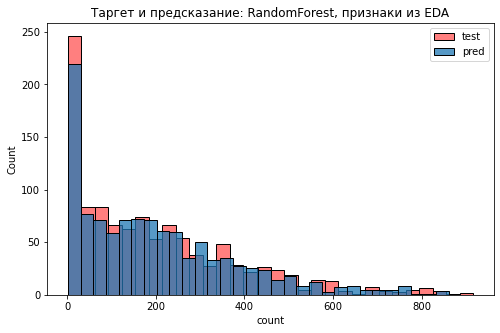

In [395]:
from sklearn.ensemble import RandomForestRegressor

# RF с логарифмированием таргета
from sklearn.compose import TransformedTargetRegressor

RF_pipe = Pipeline([('transformer', Transformer()),
                    ('model', RandomForestRegressor())])


RF_pipe.fit(X_train, y_train)
y_pred = RF_pipe.predict(X_test)
y_pred_train = RF_pipe.predict(X_train)

print(f'MSE on train: {np.mean((y_train - y_pred_train)**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: RandomForest, признаки из EDA')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

MSE on train: 564.2784771548936
MSE on test: 2104.271990663733


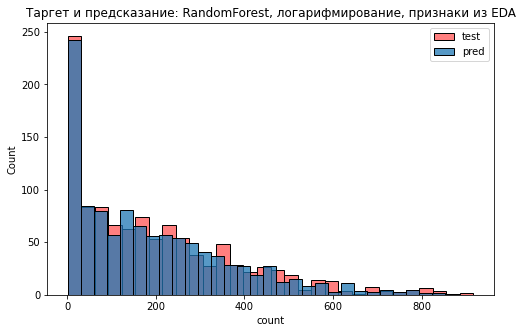

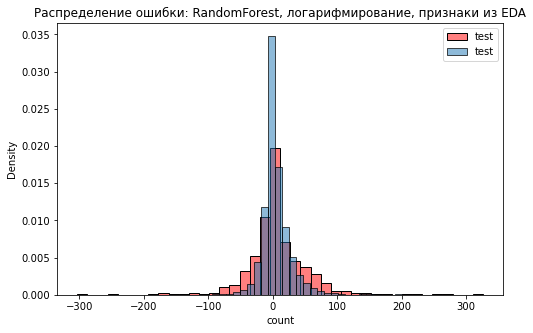

In [396]:
from sklearn.ensemble import RandomForestRegressor

# RF с логарифмированием таргета
from sklearn.compose import TransformedTargetRegressor

RF_pipe_log = Pipeline([('transformer', Transformer()),
                          ('model', RandomForestRegressor(max_features=12, n_estimators=300, max_samples=0.7))])

RF_log = TransformedTargetRegressor(
    regressor=RF_pipe_log, func=np.log1p, inverse_func=np.expm1)

RF_log.fit(X_train, y_train)
y_pred = RF_log.predict(X_test)
y_pred_train = RF_log.predict(X_train)

print(f'MSE on train: {np.mean((y_train - y_pred_train)**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: RandomForest, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

# распределение ошибки
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Распределение ошибки: RandomForest, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test - y_pred, bins=40, label='test', color='r', alpha=0.5, stat="density")
sns.histplot(ax=ax, x=y_train - y_pred_train, bins=40, label='test', alpha=0.5, stat="density")
ax.legend()

#### Градиентный бустинг

MSE on train: 1061.3922170986075
MSE on test: 2349.51740616782
RMSLE on test: 0.3107642953183231


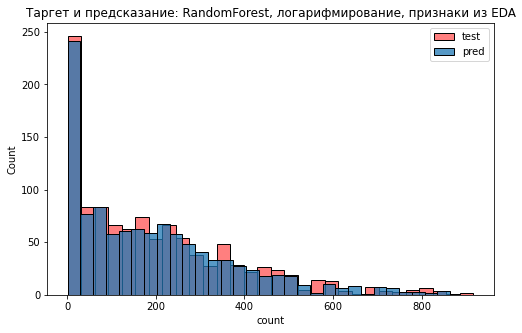

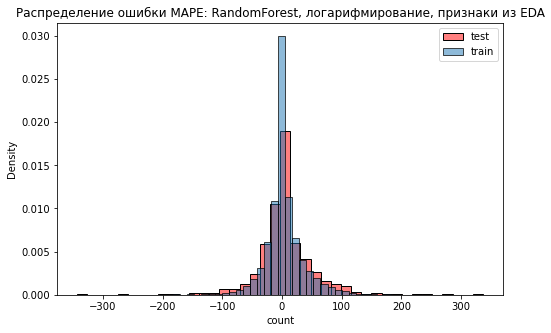

In [409]:
from xgboost import XGBRegressor

# XGBoost regressor с логарифмированием таргета
from sklearn.compose import TransformedTargetRegressor

XGB_pipe_log = Pipeline([('transformer', Transformer()),
                          ('model', XGBRegressor())])

XGB_log = TransformedTargetRegressor(
    regressor=XGB_pipe_log, func=np.log1p, inverse_func=np.expm1)

XGB_log.fit(X_train, y_train)
y_pred = XGB_log.predict(X_test)
y_pred_train = XGB_log.predict(X_train)

print(f'MSE on train: {np.mean((y_train - y_pred_train)**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')
print(f'RMSLE on test: {rmsle(y_test, y_pred)}')

# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: RandomForest, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

# распределение ошибки
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Распределение ошибки MAPE: RandomForest, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test - y_pred, bins=40, label='test', color='r', alpha=0.5, stat="density")
sns.histplot(ax=ax, x=y_train - y_pred_train, bins=40, label='train', alpha=0.5, stat="density")
ax.legend()

In [412]:
# Проверка на submission
df_test = pd.read_csv("data/test.csv")
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [413]:
y_test_pred = XGB_log.predict(df_test)

In [415]:
# формируем submission:
y_test_pred = XGB_log.predict(df_test)
submission = pd.DataFrame({'datetime': df_test['datetime'], 'count': y_test_pred})
submission.to_csv('data/submission.csv', sep=',', index=False)
submission

,datetime,count
0,2011-01-20 00:00:00,9.608405
1,2011-01-20 01:00:00,5.891678
2,2011-01-20 02:00:00,3.747418
3,2011-01-20 03:00:00,1.358706
4,2011-01-20 04:00:00,1.198958
...,...,...
6488,2012-12-31 19:00:00,337.827454
6489,2012-12-31 20:00:00,216.700455
6490,2012-12-31 21:00:00,161.830078
6491,2012-12-31 22:00:00,126.983582


<b>Submission: 0.45950 </b>

#### Тюнинг градиентного бустинга

In [421]:
from sklearn.model_selection import GridSearchCV

# boosting parameters:
max_depth = [3, 5, 6, 8, 10]
learning_rate = [0.02, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3]
subsample = [0.3, 0.6, 1.0]
n_estimators = [50, 100, 120, 150]
eval_metrics = 'rmsle'

XGB_pipe_log = Pipeline([('transformer', Transformer()),
                          ('model', XGBRegressor())])

XGB_log = TransformedTargetRegressor(
    regressor=XGB_pipe_log, func=np.log1p, inverse_func=np.expm1)

param_grid = {"regressor__model__max_depth": [3, 5, 6, 8, 10], 
              "regressor__model__learning_rate": [0.02, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3], 
              "regressor__model__subsample": [0.3, 0.6, 1.0],
              "regressor__model__n_estimators": [50, 100, 120, 150]}

xgb_grid_search = GridSearchCV(XGB_log, param_grid)
xgb_grid_search.fit(X_train, y_train)

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Dmitry\AppData\

GridSearchCV(estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('transformer',
                                                                             Transformer()),
                                                                            ('model',
                                                                             XGBRegressor(base_score=None,
                                                                                          booster=None,
                                                                                          callbacks=None,
                                                                                          colsample_bylevel=None,
                                                                                          colsample_bynode=None,
                                                                                          colsample_bytree=None,
                                                                                          device=None,
                                                                                          early_stopping_rounds=None,
                                                                                          enable_categorical=False...
                                                                                          missing=nan,
                                                                                          monotone_constraints=None,
                                                                                          multi_strategy=None,
                                                                                          n_estimators=None,
                                                                                          n_jobs=None,
                                                                                          num_parallel_tree=None,
                                                                                          random_state=None, ...))])),
             param_grid={'regressor__model__learning_rate': [0.02, 0.05, 0.08,
                                                             0.1, 0.15, 0.2,
                                                             0.3],
                         'regressor__model__max_depth': [3, 5, 6, 8, 10],
                         'regressor__model__n_estimators': [50, 100, 120, 150],
                         'regressor__model__subsample': [0.3, 0.6, 1.0]})

In [425]:
xgb_grid_search.best_params_

{'regressor__model__learning_rate': 0.2,
 'regressor__model__max_depth': 8,
 'regressor__model__n_estimators': 150,
 'regressor__model__subsample': 1.0}

In [428]:
# best tuned parameters

XGB_pipe_tuned = Pipeline([('transformer', Transformer()),
                          ('model', XGBRegressor(learning_rate=0.2, max_depth=8, n_estimators=150, subsample=1.0))])

XGB_tuned = TransformedTargetRegressor(
    regressor=XGB_pipe_tuned, func=np.log1p, inverse_func=np.expm1)

XGB_tuned.fit(X_train, y_train)
y_pred = XGB_tuned.predict(X_test)
y_pred_train = XGB_tuned.predict(X_train)

print(f'MSE on train: {np.mean((y_train - y_pred_train)**2)}')
print(f'MSE on test: {np.mean((y_test - y_pred)**2)}')
print(f'RMSLE on test: {rmsle(y_test, y_pred)}')

MSE on train: 318.9580990675031
MSE on test: 1892.5576679035178
RMSLE on test: 0.2961893803672236


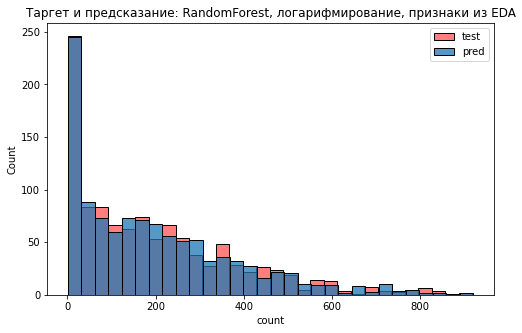

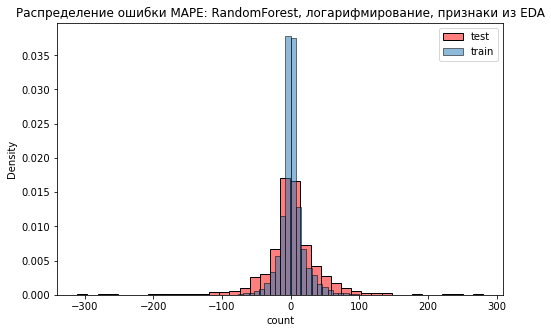

In [429]:
# Cравнение распределений таргета и предсказаний на тесте
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Таргет и предсказание: RandomForest, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test, bins=30, label='test', color='r', alpha=0.5)
sns.histplot(ax=ax, x=y_pred, bins=30, label='pred')
ax.legend()

# распределение ошибки
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Распределение ошибки MAPE: RandomForest, логарифмирование, признаки из EDA')

sns.histplot(ax=ax, x=y_test - y_pred, bins=40, label='test', color='r', alpha=0.5, stat="density")
sns.histplot(ax=ax, x=y_train - y_pred_train, bins=40, label='train', alpha=0.5, stat="density")
ax.legend()

In [430]:
# формируем submission:
y_test_pred = XGB_tuned.predict(df_test)
submission = pd.DataFrame({'datetime': df_test['datetime'], 'count': y_test_pred})
submission.to_csv('data/submission.csv', sep=',', index=False)
submission

,datetime,count
0,2011-01-20 00:00:00,8.499243
1,2011-01-20 01:00:00,5.838682
2,2011-01-20 02:00:00,2.422475
3,2011-01-20 03:00:00,1.981091
4,2011-01-20 04:00:00,1.277886
...,...,...
6488,2012-12-31 19:00:00,389.707947
6489,2012-12-31 20:00:00,213.590485
6490,2012-12-31 21:00:00,158.577972
6491,2012-12-31 22:00:00,112.755859


<b>Submission: 0.46516 </b>
<br/>Получили большую ошибку, чем без настроек бустинга. Скорее всего это связано с подстройкой под трейн и отличием данных на окончательном тесте. В данных submission приведены данные по концам месяца, этих данных нет в трейне. Поэтому есть смысл подумать как доработать валидацию модели (сделать разбиение по времени) и улучшить прогноз на конец месяца.

Предложения по доработкам:
- валидация по последним дням месяца в трейне (от 15 до 20 например);
- последние дни месяца близки к первым дням следующего месяца, поаэтому есть смысл перейти от категориальных признаков месяца к "расстояниям", например взять синусы и косинусы (представить дату как градус на круге).